In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

from mie2c.e2c import E2C, compute_loss, PWATransition, train_vae
from mie2c.ball_model import (get_ball_encoder, get_ball_decoder,
    get_ball_transition, get_ball_linear_transition, get_ball_pwa_transition)
from mie2c.losses import SigmoidAnneal

### Method to create (3,32,32) tensor

In [ ]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [ ]:
def step(x0, Ak, add_noise=False):
    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [ ]:
n = 4 
dh = 0.05

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32

# Training data
NUM_DATA = 10000

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    if x0[0] < .5 * posbounds[1]:
        x0[2] *= -1.
    
    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

# Test data
NUM_TEST = 1000

X_test = np.zeros((NUM_TEST,3,W,W))
X_next_test = np.zeros((NUM_TEST,3,W,W))

count = 0
while count < NUM_TEST:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    if x0[0] < .5 * posbounds[1]:
        x0[2] *= -1.
    
    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X_test[count,:,:,:] = img
    X_next_test[count,:,:,:] = img_new

    count += 1

In [ ]:
# convert to grayscale
gray_w = [0.3, 0.59, 0.11]
def to_gray(Y):
    return gray_w[0] * Y[:, 0:1, :, :] + gray_w[1] * Y[:, 1:2, :, :] + gray_w[2] * Y[:, 2:3, :, :]
X = to_gray(X)
X_next = to_gray(X_next)
X_test = to_gray(X_test)
X_next_test = to_gray(X_next_test)

In [ ]:
np.save('benchmark_X.npy', X)
np.save('benchmark_X_next.npy', X_next)
np.save('benchmark_X_test.npy', X_test)
np.save('benchmark_X_next_test.npy', X_next_test)

In [3]:
X = np.load('benchmark_X.npy')
X_next = np.load('benchmark_X_next.npy')
X_test = np.load('benchmark_X_test.npy')
X_next_test = np.load('benchmark_X_next_test.npy')
NUM_DATA = X.shape[0]
NUM_TEST = X_test.shape[0]

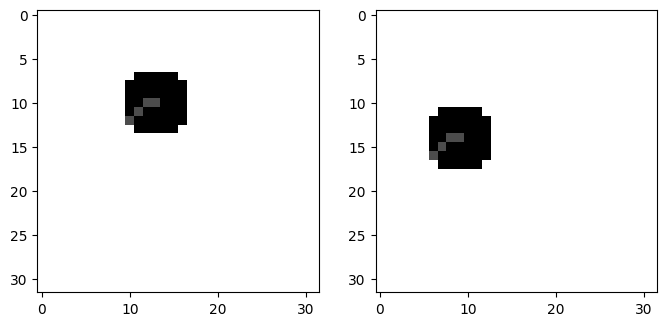

In [4]:
idx = np.random.choice(NUM_DATA)
img, img_next = X[idx], X_next[idx]

plt.style.use('default')
fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
# plt.imshow(img.transpose(1,2,0))
plt.imshow(img[0,:], cmap='gray')

fig.add_subplot(1,2,2)
# plt.imshow(img_next.transpose(1,2,0))
plt.imshow(img_next[0,:], cmap='gray')

# Training Options

In [4]:
dim_z = 4
dim_u = 0
use_cuda = True
num_epochs = 500
batch_size = 32
checkpoint_every = 1
savepoint_every = 1
learning_rate = 5e-4
kl_lo = 1e-3
kl_up = 1.
kl_center_step = 20
kl_steps_lo_to_up = 10
temp_lo = 1e-3
temp_up = 100.
temp_center_step = 100
temp_steps_lo_to_up = 50
use_l2 = False

dim_in = X[0].shape
kl_lambda = SigmoidAnneal(torch.float32, kl_lo, kl_up, kl_center_step, kl_steps_lo_to_up)
temp_lambda = SigmoidAnneal(torch.float32, temp_lo, temp_up, temp_center_step, temp_steps_lo_to_up)

# E2C Transition

In [5]:
encoder = get_ball_encoder(dim_in, dim_z)
e2c_transition = get_ball_transition(dim_z, dim_u)
decoder = get_ball_decoder(dim_z, dim_in)

fn_e2c = 'model_e2c'
model_e2c = E2C(encoder, e2c_transition, decoder)

writer = None
itr = 0

In [6]:
if os.path.exists('pytorch/{}.pt'.format(fn_e2c)):
    model_e2c.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_e2c)))

In [ ]:
writer, itr = train_vae(model_e2c, X, X_next, fn_e2c, verbose=True, use_cuda=use_cuda,
                        num_epochs=num_epochs, batch_size=batch_size,
                        checkpoint_every=checkpoint_every, savepoint_every=savepoint_every,
                        learning_rate=learning_rate,
                        kl_lambda=kl_lambda, temp_lambda=temp_lambda, use_l2=use_l2,
                        writer=writer, itr=itr)

In [ ]:
model_e2c.cpu()

# Linear Transition

In [7]:
use_low_rank = False  # True if A = I + r*v^T

encoder = get_ball_encoder(dim_in, dim_z)
lin_transition = get_ball_linear_transition(dim_z, dim_u, low_rank=use_low_rank)
decoder = get_ball_decoder(dim_z, dim_in) 

fn_lin = 'model_lin'
model_lin = E2C(encoder, lin_transition, decoder)

writer = None
itr = 0

In [8]:
if os.path.exists('pytorch/{}.pt'.format(fn_lin)):
    model_lin.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_lin)))

In [ ]:
writer, itr = train_vae(model_lin, X, X_next, fn_lin, verbose=True, use_cuda=use_cuda,
                        num_epochs=num_epochs, batch_size=batch_size,
                        checkpoint_every=checkpoint_every, savepoint_every=savepoint_every,
                        learning_rate=learning_rate,
                        kl_lambda=kl_lambda, temp_lambda=temp_lambda, use_l2=use_l2,
                        writer=writer, itr=itr)

In [ ]:
model_lin.cpu()

In [ ]:
torch.version.cuda

# PWA Transition

In [9]:
use_low_rank = False  # True if A = I + r*v^T
num_modes = 2

encoder = get_ball_encoder(dim_in, dim_z)
pwa_transition = get_ball_pwa_transition(num_modes, dim_z, dim_u, low_rank=use_low_rank)
decoder = get_ball_decoder(dim_z, dim_in) 

fn_pwa = 'model_pwa'
model_pwa = E2C(encoder, pwa_transition, decoder)

writer = None
itr = 0

In [10]:
if os.path.exists('pytorch/{}.pt'.format(fn_pwa)):
    model_pwa.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_pwa)))

In [ ]:
writer, itr = train_vae(model_pwa, X, X_next, fn_pwa, verbose=True, use_cuda=use_cuda,
                        num_epochs=num_epochs, batch_size=batch_size,
                        checkpoint_every=checkpoint_every, savepoint_every=savepoint_every,
                        learning_rate=learning_rate,
                        kl_lambda=kl_lambda, temp_lambda=temp_lambda, use_l2=use_l2,
                        writer=writer, itr=itr)

In [ ]:
model_pwa.trans.temperature

In [ ]:
model_pwa.cpu()

# Evaluation

In [11]:
bce_loss = torch.nn.BCELoss(reduction='none').float()

x_pred_e2c = model_e2c.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float()).detach()
# l2_err_e2c = (x_pred_e2c - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()
l2_err_e2c = bce_loss(x_pred_e2c, torch.tensor(X_test).float()).cpu().numpy().sum(axis=1).sum(axis=1).sum(axis=1)

x_pred_lin = model_lin.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float()).detach()
# l2_err_lin = (x_pred_lin - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()
l2_err_lin = bce_loss(x_pred_lin, torch.tensor(X_test).float()).cpu().numpy().sum(axis=1).sum(axis=1).sum(axis=1)

x_pred_pwa = model_pwa.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float()).detach()
# l2_err_pwa = (x_pred_pwa - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()
l2_err_pwa = bce_loss(x_pred_pwa, torch.tensor(X_test).float()).cpu().numpy().sum(axis=1).sum(axis=1).sum(axis=1)

print("e2c: " + str(l2_err_e2c.mean()))
print("linear: " + str(l2_err_lin.mean()))
print("pwa: " + str(l2_err_pwa.mean()))

tensor(1000.)
tensor(0.)
e2c: 4408.196
linear: 2772.0388
pwa: 1266.913


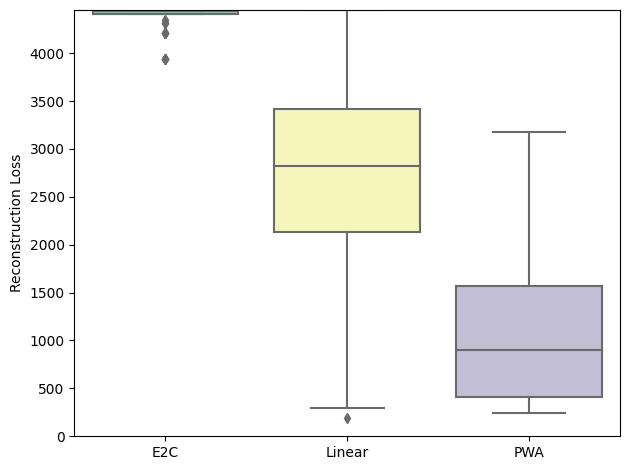

In [30]:
results = dict()
results['E2C'] = l2_err_e2c
results['Linear'] = l2_err_lin
results['PWA'] = l2_err_pwa

results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Reconstruction Loss")

plt.tight_layout()
plt.ylim(0, int(math.ceil(np.max(np.maximum(l2_err_lin, l2_err_e2c, l2_err_pwa)) / 10.0)) * 10)

figure = ax1.get_figure()
figure.savefig("loss.pdf")

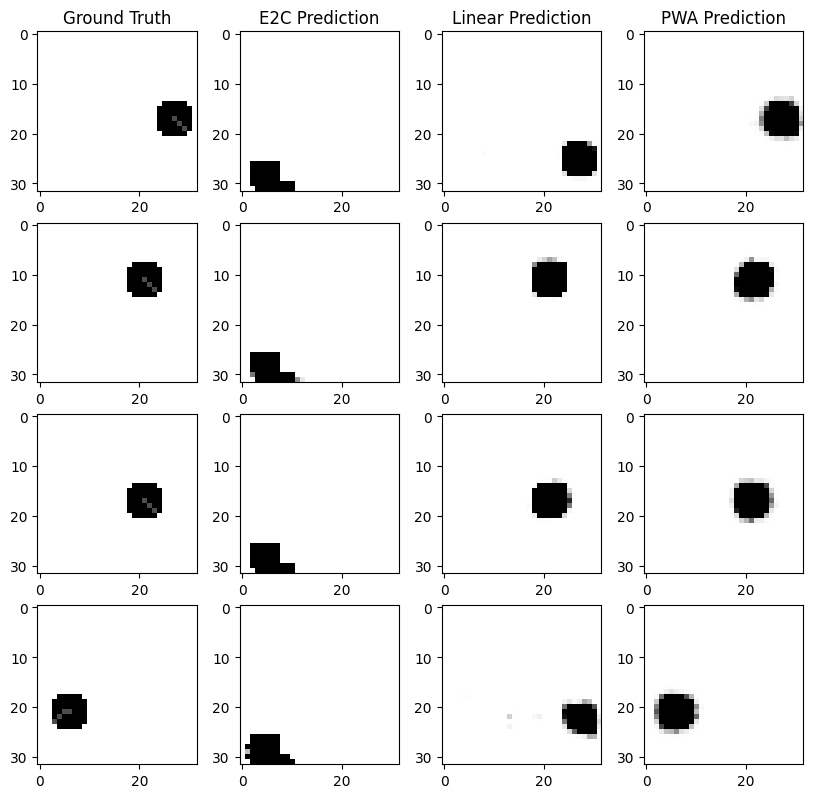

In [31]:
plt.style.use('default')
fig = plt.figure(figsize=(10,12))

N = 4
for i in range(N):
    idx = np.random.choice(NUM_TEST)

    fig.add_subplot(N+1,4,i*4+1)
    if i == 0:
        plt.title("Ground Truth")
#     plt.imshow(X_next_test[idx].transpose(1,2,0))
    plt.imshow(X_next_test[idx].transpose(1,2,0), cmap='gray')


    fig.add_subplot(N+1,4,i*4+2)
    if i == 0:
        plt.title("E2C Prediction")
# #     plt.imshow(x_pred_e2c[idx].detach().numpy().transpose(1,2,0))
    plt.imshow(x_pred_e2c[idx].detach().numpy().transpose(1,2,0), cmap='gray')


    fig.add_subplot(N+1,4,i*4+3)
    if i == 0:
        plt.title("Linear Prediction")
#     plt.imshow(x_pred_lin[idx].detach().numpy().transpose(1,2,0))
    plt.imshow(x_pred_lin[idx].detach().numpy().transpose(1,2,0), cmap='gray')

    fig.add_subplot(N+1,4,i*4+4)
    if i == 0:
        plt.title("PWA Prediction")
#     plt.imshow(x_pred_pwa[idx].detach().numpy().transpose(1,2,0))
    plt.imshow(x_pred_pwa[idx].detach().numpy().transpose(1,2,0), cmap='gray')

fig.savefig("predictions.pdf")